In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import itertools
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Train.csv')
val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Val.csv')

In [ ]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

stop_words = set(stopwords.words("english")) # create list of stop words

def cleantext(string):
    text = string.lower().split() # convert letters to lowercase and split claims ('tweets') into separate words
    text = " ".join(text) # ???
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text) # replace '&' with ' and '
    text = text.replace('&amp',' ') # replace '&amp' with empty space
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # replace non-letters, non-numbers, & punctuation with empty space
    text = text.split() # ??? 
    #text = [ps.stem(word) for word in text] # set text equal to stemmed words
    text = [w for w in text if not w in stop_words] # Lemmatization
    text = [lemmatizer.lemmatize(w) for w in text] # remove stop words 
    text = " ".join(text) # joining the seperated pieces of string into one string
    return text

# apply cleantext() function to all tweets 
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
#test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

[nltk_data] Downloading package wordnet to /Users/marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train['tweet'].head(10)

0    cdc currently report 99031 death general discr...
1    state reported 1121 death small rise last tues...
2    politically correct woman almost us pandemic e...
3    indiafightscorona 1524 covid testing laborator...
4    populous state generate large case count look ...
5    covid act found average person illinois covid ...
6    tested positive covid19 symptom stay home away...
7    obama call trump coronavirus response chaotic ...
8    clearly obama administration leave kind game p...
9    retraction hydroxychloroquine chloroquine with...
Name: tweet, dtype: object

## SVM for Reference

In [ ]:
#SVM
from sklearn.svm import LinearSVC
# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', LinearSVC()) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrics(pred,val['label'])
#plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of DT on val data')

## First XGB

In [ ]:
# XGBoost Classifier

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(max_depth=20, min_child_weight=2)) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrics(pred,val['label'])
#plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of DT on val data')

XGBoost
val:
[[ 932   88]
 [ 104 1016]]
              precision    recall  f1-score   support

        fake       0.90      0.91      0.91      1020
        real       0.92      0.91      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.9102803738317757
Precison :  0.9103295897798372
Recall :  0.9102803738317757
F1 :  0.9102540026962392


## Second XGB

In [ ]:
# XGBoost Classifier

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(max_depth=25, min_child_weight=2, objective="binary:logistic", n_estimators = 100, verbosity = 0)) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrics(pred,val['label'])
#plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of DT on val data')

XGBoost
val:
[[ 928   92]
 [  99 1021]]
              precision    recall  f1-score   support

        fake       0.90      0.91      0.91      1020
        real       0.92      0.91      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.9107476635514019
Precison :  0.9107417651640095
Recall :  0.9107476635514019
F1 :  0.9107349521329184


## GridSearch

In [ ]:
from pprint import pprint
from time import time
import logging

#from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
model = XGBClassifier()

pipeline = Pipeline([
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ('model', XGBClassifier()),
])

param_grid = {
    'model__max_depth': [21,22,23,24,25,26],
    #'model__n_estimators': [100, 200, 300],
    'model__min_child_weight': [1]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid.fit(train['tweet'],train['label'])
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

In [ ]:
print(f"Best parameters: {grid.best_params_}")
#print(f"Mean CV score: {mean_score: .6f}")
#print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__max_depth': 25, 'model__min_child_weight': 1}


## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = { 'model__max_depth': [3, 5, 6, 10, 15, 20,23,25],
           'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
           'model__subsample': np.arange(0.5, 1.0, 0.1),
           'model__colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'model__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'model__n_estimators': [100, 500, 1000]
          }

model = XGBClassifier()

pipeline = Pipeline([
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ('model', XGBClassifier(**params)),
])


grid = RandomizedSearchCV(pipeline, param_distributions=params, scoring='neg_mean_squared_error', n_iter=25, verbose=1)

grid.fit(train['tweet'],train['label'])
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
print(f"Best parameters: {grid.best_params_}")
#print(f"Mean CV score: {mean_score: .6f}")
#print(f"Standard deviation of CV score: {std_score: .6f}")



## HyperOpt via AUC (0.9172540807314424)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('punkt')
from hyperopt.pyll.stochastic import sample
from hyperopt.pyll.base import scope
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, rand, pyll
from scipy.stats.kde import gaussian_kde
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, Normalizer, normalize, scale, FunctionTransformer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

[nltk_data] Downloading package punkt to /Users/marco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
conda install -c conda-forge hyperopt

In [ ]:
conda install -c conda-forge/label/gcc7 hyperopt 

In [ ]:
conda install -c conda-forge/label/cf201901 hyperopt

In [ ]:
conda install -c conda-forge/label/cf202003 hyperopt

In [ ]:
# Additional split of the validation set
from sklearn.model_selection import train_test_split

X_valid, X_test, y_train, y_test = train_test_split(val['tweet'], val['label'], test_size=0.5, random_state=42)

In [ ]:
# TfidfVectorizer Maximum nuber of features

max_features = 3000

# tf-idf vectorizer for sentence/topic/document modelling

tvec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 1), max_df=0.65,
                       tokenizer=nltk.word_tokenize,
                       strip_accents='unicode',
                       lowercase=True, analyzer='word',
                       use_idf=True, smooth_idf=True, sublinear_tf=False,
                       #stop_words=stopwords.words('english')
                       )

# Fit & Transform on train texts
# Only transform on val & test texts

train_X = tvec.fit_transform(train['tweet']).toarray()
valid_X = tvec.transform(X_valid).toarray()
test_X = tvec.transform(X_test).toarray()

train_y = train['label']
valid_y = y_train
test_y = y_test

In [ ]:
train_val_tf = np.append(train_X, valid_X, axis=0)
label_val_tf = np.append(train_y, valid_y, axis=0)

In [ ]:
# Parameter's space

hyper_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 200, 600, 1)),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
    'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 30, dtype=int))),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05)
}

print('Sampling space example\n')
pprint(sample(hyper_space))

Sampling space example

{'eta': 0.2,
 'max_depth': 17,
 'min_child_weight': 4.0,
 'n_estimators': 228,
 'subsample': 1.0}


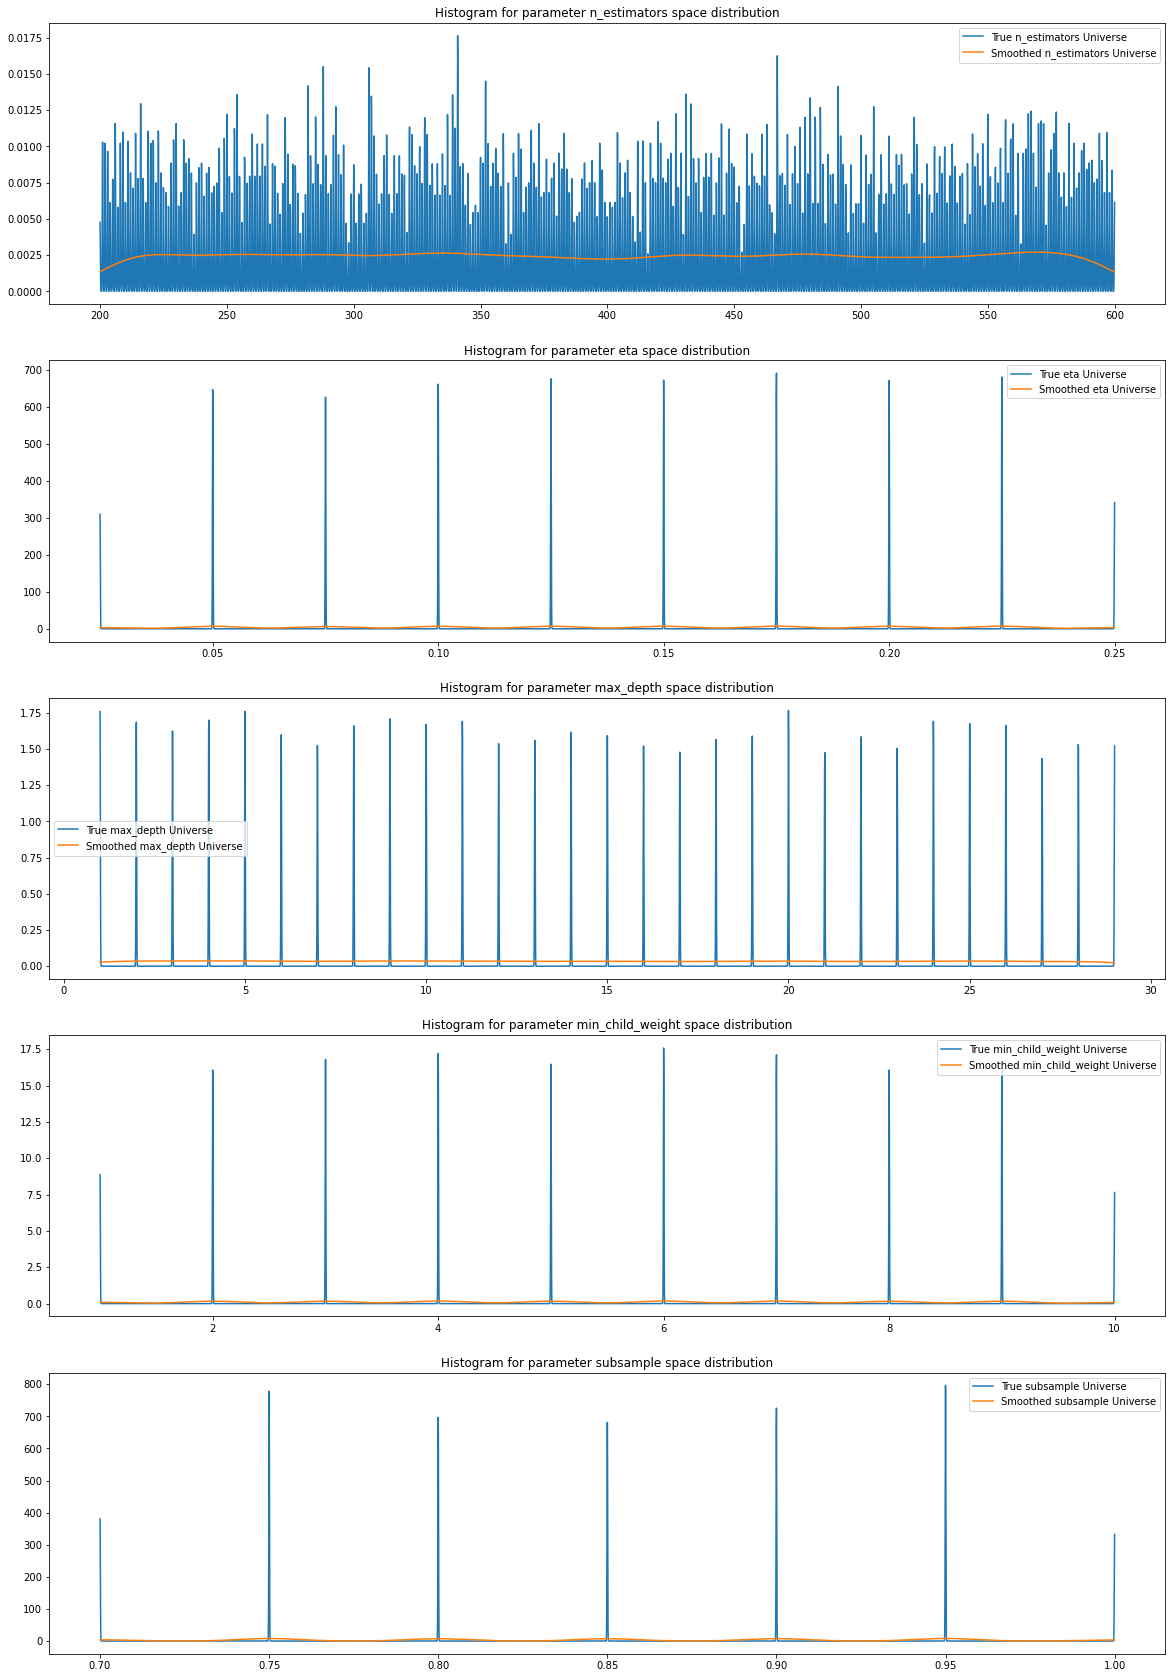

In [ ]:
# Plot different parameter's space distribution after sampling for n_samples

n_samples = 5000
universe = {}

fig, axes = plt.subplots(nrows=len(hyper_space.keys()),
                         ncols=1, figsize=(20, 30))
cmap = plt.cm.jet

# Iterating over different trials & parameters
for index, (param, param_space) in enumerate(hyper_space.items()):

    # Sampling for n_samples
    universe[param] = [pyll.stochastic.sample(
        hyper_space[param]) for _ in range(n_samples)]
    param_domain = np.linspace(
        min(universe[param]), max(universe[param]), n_samples)

    # KDE calculation
    hist = gaussian_kde(universe[param], 0.001)
    axes[index].plot(param_domain, hist(param_domain),
                     label='True {} Universe'.format(param))

    blurred_hist = gaussian_kde(universe[param], 0.1)
    axes[index].plot(param_domain, blurred_hist(param_domain),
                     label='Smoothed {} Universe'.format(param))

    axes[index].set_title(
        'Histogram for parameter {} space distribution'.format(param))
    axes[index].legend()

plt.show()

In [ ]:
iterations = 10
random_state = 21
cores = -1
best = 0

# Define the XGB  function as the objective


def objective(space):

    global best

    train_X_ = train_X
    valid_X_ = valid_X
    test_X_ = test_X

    # Normalizing or scaling the data
    if 'normalize' in space:
        if space['normalize'] == 1:
            train_X_ = normalize(train_X_)
            valid_X_ = normalize(valid_X_)
            test_X_ = normalize(test_X_)
            del space['normalize']

    if 'scale' in space:
        if space['scale'] == 1:
            train_X_ = scale(train_X_)
            valid_X_ = scale(valid_X_)
            test_X_ = scale(test_X_)
            del space['scale']

    eval_set = [(train_X, train_y), (valid_X, valid_y)]

    clf = XGBClassifier(n_estimators=space['n_estimators'],
                        learning_rate=space['eta'],
                        max_depth=space['max_depth'],
                        min_child_weight=space['min_child_weight'],
                        subsample=space['subsample'],
                        n_jobs=-1
                        )

    clf.fit(train_X, train_y,
            eval_set=eval_set, eval_metric="auc",
            # early_stopping_rounds=100,
            verbose=False)

    # evaluate predictions
    # predictions_prob = clf.predict_proba(test_X, ntree_limit=clf.best_iteration + 1)[:,1]
    predictions_prob = clf.predict_proba(test_X)[:, 1]
    auc = roc_auc_score(test_y, predictions_prob)

    if auc > best:
        best = auc
        print('\nBest AUC score: {}'.format(np.round(best*100, 2)))
        print('Space Parameters\n')
        pprint(space)

    return {'loss': 1-auc, 'status': STATUS_OK}


space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 600, 50)),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
    'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 30, dtype=int))),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}


print('Sampling space example\n')
pprint(sample(space))

# Trials keeps track of all experiments; These can be saved and loaded back into a new batch of experiments
tpe_auc_trials = Trials()

# The algorithm tpe.suggest runs the Tree-structured Parzen estimator
best_tpe_auc = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=iterations,
                    trials=tpe_auc_trials)

print('\n\nThe best parameteres discovered through HyperOpt tpe.suggest algorithm using AUC as an evaluation metric\n\n', best_tpe_auc)

Sampling space example

{'eta': 0.125,
 'max_depth': 9,
 'min_child_weight': 10.0,
 'n_estimators': 50,
 'normalize': 0,
 'scale': 0,
 'subsample': 0.75}
                                                                                
Best AUC score: 94.87
Space Parameters                                                                

{                                                                               
'eta'                                                                           
:                                                                               
0.1                                                                             
,                                                                               
 
'max_depth'                                                                     
:                                                                               
10                                                                              
,          

:                                                                               
2.0                                                                             
,                                                                               
 
'n_estimators'                                                                  
:                                                                               
350                                                                             
,                                                                               
 
'normalize'                                                                     
:                                                                               
0                                                                               
,                                                                               
 
'scale'                                                                         
:                     

In [ ]:
# XGBoost Classifier

params = {
          'eta': 0.2, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 350, 'normalize': 0, 'scale': 0, 'subsample': 0.75         }

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(**params, objective='binary:logistic')) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrics(pred,val['label'])
#plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of DT on val data')

XGBoost
val:
[[ 931   89]
 [  98 1022]]
              precision    recall  f1-score   support

        fake       0.90      0.91      0.91      1020
        real       0.92      0.91      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.9126168224299065
Precison :  0.9126178532160527
Recall :  0.9126168224299065
F1 :  0.9126011668122543


test parameters Best: (F1 :  0.9172540807314424)

In [ ]:
# XGBoost Classifier

params = {
          'eta': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 550, 'scale': 1, 'subsample': 0.8500000000000001
         }

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(**params, objective='binary:logistic')) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrics(pred,val['label'])
#plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of DT on val data')

XGBoost
val:
[[ 945   75]
 [ 102 1018]]
              precision    recall  f1-score   support

        fake       0.90      0.93      0.91      1020
        real       0.93      0.91      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140

Accuracy :  0.9172897196261682
Precison :  0.917511044137281
Recall :  0.9172897196261682
F1 :  0.9172540807314424


## Optimization of F1 via cross validation (0.9158524706271935) 

In [ ]:
from sklearn.model_selection import cross_val_score


N_FOLDS = 10
MAX_EVALS = 50

space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 600, 50)),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
    'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 30, dtype=int))),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
    
}

def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC

    clf = XGBClassifier(**params,random_state=0,verbose =0)
    scores = cross_val_score(clf, tf_idf_train, train['label'], cv=5, scoring='f1_macro')

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}



# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

100%|███████████| 50/50 [13:39<00:00, 16.38s/it, best loss: 0.07644937397931417]


In [ ]:
best

{'eta': 0.1,
 'max_depth': 13,
 'min_child_weight': 1.0,
 'n_estimators': 300.0,
 'normalize': 0,
 'scale': 1,
 'subsample': 0.9}

In [ ]:
# XGBoost Classifier

params = {'eta': 0.1,
 'max_depth': 13,
 'min_child_weight': 1,
 'n_estimators': 300,
 'normalize': 0,
 'scale': 1,
 'subsample': 0.9}

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(**params, objective='binary:logistic')) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrics(pred,val['label'])
#plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
#                      title = 'Confusion matix of DT on val data')

XGBoost
val:
[[ 943   77]
 [ 103 1017]]
              precision    recall  f1-score   support

        fake       0.90      0.92      0.91      1020
        real       0.93      0.91      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140

Accuracy :  0.9158878504672897
Precison :  0.9160880029581927
Recall :  0.9158878504672897
F1 :  0.9158524706271935


In [ ]:
# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1))
tf_idf_transformer = TfidfTransformer(smooth_idf=True)

# fit and transform train data to count vectorizer
count_vectorizer.fit(train['tweet'].values)
count_vect_train = count_vectorizer.transform(train['tweet'].values)

# fit the counts vector to tfidf transformer
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

# Transform the test data as well
count_vect_test = count_vectorizer.transform(val['tweet'].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

In [ ]:
tf_idf_test

<2140x12982 sparse matrix of type '<class 'numpy.float64'>'
	with 31200 stored elements in Compressed Sparse Row format>

In [ ]:
space={'max_depth': hp.quniform("max_depth", 1, 30, 1),
       #'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 600, 50),
        'seed': 0
    }


In [ ]:
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 600, 50)),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
    'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 30, dtype=int))),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

In [ ]:
#iterations = 200
random_state = 21
cores = -1
best = 0

def objective(space):

    global best
    
    #clf=XGBClassifier(
     #               n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
      #              reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
       #             colsample_bytree=int(space['colsample_bytree']))
    
    clf = XGBClassifier(n_estimators=space['n_estimators'],
                        learning_rate=space['eta'],
                        max_depth=space['max_depth'],
                        min_child_weight=space['min_child_weight'],
                        subsample=space['subsample'],
                        n_jobs=-1
                        )
    
    evaluation = [(tf_idf_train, train['label']), (tf_idf_test, val['label'])]
    
    clf.fit(tf_idf_train, train['label'],
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    





    pred = clf.predict_proba(tf_idf_test)[:, 1]
    #accuracy = accuracy_score(val['label'], pred)#>0.5
    #print ("SCORE:", accuracy)
    auc = roc_auc_score(val['label'], pred)
    print ("SCORE:", auc)
    #auc = accuracy_score(val['label'], pred)
    if auc > best:
        best = auc
        print('\nBest AUC score: {}'.format(np.round(best*100, 2)))
        print('Space Parameters\n')
        pprint(space)

    #return {'loss': -accuracy, 'status': STATUS_OK }
    return {'loss': 1-auc, 'status': STATUS_OK}

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

SCORE:
0.9567533263305322

Best AUC score: 95.68
Space Parameters

{
'eta'
: 
0.125
,
 
'max_depth'
: 
17
,
 
'min_child_weight'
: 
8.0
,
 
'n_estimators'
: 
200
,
 
'normalize'
: 
0
,
 
'scale'
: 
1
,
 
'subsample'
: 
0.9
}
SCORE:
0.9575017507002801

Best AUC score: 95.75
Space Parameters

{
'eta'
: 
0.17500000000000002
,
 
'max_depth'
: 
2
,
 
'min_child_weight'
: 
5.0
,
 
'n_estimators'
: 
200
,
 
'normalize'
: 
0
,
 
'scale'
: 
0
,
 
'subsample'
: 
0.9500000000000001
}
SCORE:
0.9603667717086835

Best AUC score: 96.04
Space Parameters

{
'eta'
: 
0.25
,
 
'max_depth'
: 
2
,
 
'min_child_weight'
: 
7.0
,
 
'n_estimators'
: 
550
,
 
'normalize'
: 
1
,
 
'scale'
: 
0
,
 
'subsample'
: 
1.0
}
SCORE:
0.9578313200280113
SCORE:
0.9543172268907564
SCORE:
0.9252516631652662
SCORE:
0.9528216911764704
SCORE:
0.9523402485994398
SCORE:
0.770905549719888
SCORE:
0.9649934348739495

Best AUC score: 96.5
Space Parameters

{
'eta'
: 
0.2
,
 
'max_depth'
: 
23
,
 
'min_child_weight'
: 
5.0
,
 
'n_esti

F1 :  0.910738387943888



In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'eta': 0.07500000000000001, 'max_depth': 20, 'min_child_weight': 3.0, 'n_estimators': 200.0, 'normalize': 0, 'scale': 0, 'subsample': 0.9500000000000001}


F1 :  0.8793819099182772

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'eta': 0.15000000000000002, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 500.0, 'normalize': 0, 'scale': 1, 'subsample': 0.8}


0,913

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'eta': 0.05, 'max_depth': 14, 'min_child_weight': 2.0, 'n_estimators': 350.0, 'normalize': 0, 'scale': 0, 'subsample': 0.9}


In [ ]:
def objective(space):
    
    clf = XGBClassifier(n_estimators=space['n_estimators'],
                        learning_rate=space['eta'],
                        max_depth=space['max_depth'],
                        min_child_weight=space['min_child_weight'],
                        subsample=space['subsample'],
                        n_jobs=-1
                        )
    
    evaluation = [(tf_idf_train, train['label']), (tf_idf_test, val['label'])]
    
    clf.fit(tf_idf_train, train['label'],
            eval_set=evaluation, eval_metric="auc",
            #early_stopping_rounds=10,
            verbose=False)
    
    pred = clf.predict(tf_idf_test)
    accuracy = accuracy_score(val['label'], pred)#>0.5
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 2,
                        trials = trials)

NameError: ignored

In [ ]:
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score)

space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 600, 50)),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
    'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 30, dtype=int))),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
    #'scale': hp.choice('scale', [0, 1]),
    #'normalize': hp.choice('normalize', [0, 1])
}

def objective(space):
    
    clf = XGBClassifier(n_estimators=space['n_estimators'],
                        learning_rate=space['eta'],
                        max_depth=space['max_depth'],
                        min_child_weight=space['min_child_weight'],
                        subsample=space['subsample'],
                        n_jobs=-1
                        )
    
    evaluation = [(tf_idf_train, train['label']), (tf_idf_test, val['label'])]
    
    clf.fit(tf_idf_train, train['label'],
            eval_set=evaluation, 
            #eval_metric="auc",
            #early_stopping_rounds=10,
            verbose=False)
    
    pred = clf.predict(tf_idf_test)
    #accuracy = accuracy_score(val['label'], pred)#>0.5
    #print ("SCORE:", accuracy)
    #return {'loss': -accuracy, 'status': STATUS_OK }

    pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(val['label'], pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 2,
                        trials = trials)

  0%|                                       | 0/2 [00:00<?, ?it/s, best loss: ?]


TypeError: '>=' not supported between instances of 'str' and 'float'